##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# 回帰：燃費を予測する

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/keras/regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で表示</a></td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab で実行</a> </td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/keras/regression.ipynb">     <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">     GitHubでソースを表示</a></td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a> </td>
</table>

回帰問題では、価格や確率といった連続的な値の出力を予測することが目的となります。これは、分類問題の目的が、（たとえば、写真にリンゴが写っているかオレンジが写っているかといった）離散的なラベルを予測することであるのとは対照的です。

このノートブックでは、古典的な [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) データセットを使用し、1970 年代後半から 1980 年台初めの自動車の燃費を予測するモデルを構築します。この目的のため、モデルにはこの時期の多数の自動車の仕様を読み込ませます。仕様には、気筒数、排気量、馬力、重量などが含まれています。

このサンプルでは`tf.keras` APIを使用しています。詳細は[このガイド](https://www.tensorflow.org/guide/keras)を参照してください。

In [ ]:
# Use seaborn for pairplot.
!pip install -q seaborn

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.8.0


## Auto MPG データセット

このデータセットは[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/)から入手可能です。


### データの取得

まず、データセットをダウンロードします。

In [ ]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [ ]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### データのクレンジング

このデータセットには、いくつか欠損値があります。

In [ ]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

この最初のチュートリアルでは簡単化のためこれらの行を削除します。

In [ ]:
dataset = dataset.dropna()

In [ ]:
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


`"Origin"` 列はカテゴリであり、数値ではないので、[pd.get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) でワンホットに変換します。

注意: `keras.Model` を設定して、このような変換を行うことができます。これについては、このチュートリアルでは取り上げません。例については、[前処理レイヤー](../structured_data/preprocessing_layers.ipynb)または [CSV データの読み込み](../load_data/csv.ipynb)のチュートリアルをご覧ください。

In [ ]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,USA
1,15.0,8,350.0,165.0,3693.0,11.5,70,USA
2,18.0,8,318.0,150.0,3436.0,11.0,70,USA
3,16.0,8,304.0,150.0,3433.0,12.0,70,USA
4,17.0,8,302.0,140.0,3449.0,10.5,70,USA


In [ ]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


### データをトレーニング用セットとテスト用セットに分割

次に、データセットをトレーニングセットとテストセットに分割します。モデルの最終評価ではテストセットを使用します。

In [ ]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### データの観察

トレーニング用セットの列のいくつかのペアの同時分布を見てみます。

一番上の行を見ると、燃費 (MPG) が他のすべてのパラメータの関数であることは明らかです。他の行を見ると、それらが互いの関数であることが明らかです。

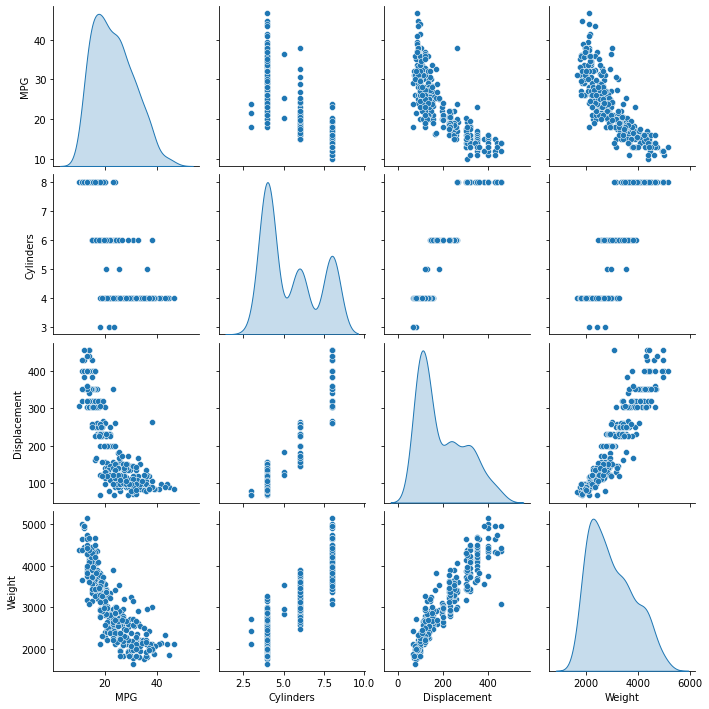

In [ ]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

全体の統計値も見てみましょう。

In [ ]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


### ラベルと特徴量の分離

ラベル、すなわち目的変数を特徴量から分離します。このラベルは、モデルに予測させたい数量です。

In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

## 正規化

統計の表を見て、それぞれの特徴量の範囲がどれほど違っているかに注目してください。

In [ ]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


スケールや値の範囲が異なる特徴量を正規化するのはよい習慣です。

これが重要な理由の 1 つは、特徴にモデルの重みが掛けられるためです。したがって、出力のスケールと勾配のスケールは、入力のスケールの影響を受けます。

モデルは特徴量の正規化なしで収束する可能性がありますが、正規化によりトレーニングがはるかに安定します。

注意: ここでは、簡単にするため実行しますが、ワンホット特徴を正規化する利点はありません。前処理レイヤーの使用方法の詳細については、[前処理レイヤーの使用](https://www.tensorflow.org/guide/keras/preprocessing_layers)ガイドと [Keras 前処理レイヤーを使用した構造化データの分類](https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers)チュートリアルを参照してください。

### 正規化レイヤー

`preprocessing.Normalization` レイヤーは、その前処理をモデルに組み込むためのクリーンでシンプルな方法です。

まず、レイヤーを作成します。

In [ ]:
normalizer = tf.keras.layers.Normalization(axis=-1)

次にデータに `.adapt()` します。

In [ ]:
normalizer.adapt(np.array(train_features))

これにより、平均と分散が計算され、レイヤーに保存されます。

In [ ]:
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


レイヤーが呼び出されると、入力データが返され、各特徴は個別に正規化されます。

In [ ]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


## 線形回帰

DNN モデルを構築する前に、単一変数および複数変数を使用した線形回帰から始めます。

### 1 つの変数

単一変数の線形回帰から始めて、`Horsepower` から `MPG` を予測します。

`tf.keras` を使用したモデルのトレーニングは、通常、モデルアーキテクチャを定義することから始まります。ここでは、`tf.keras.Sequential` モデルを使用します。このモデルは、[一連のステップ](https://www.tensorflow.org/guide/keras/sequential_model)を表します。

単一変数の線形回帰モデルには、次の 2 つのステップがあります。

- 入力 `horsepower` を正規化します。
- 線形変換 ($y = mx+b$) を適用して、`layers.Dense` を使用して 1 つの出力を生成します。

*入力*の数は、`input_shape` 引数により設定できます。また、モデルを初めて実行するときに自動的に設定することもできます。

まず、馬力 `Normalization` レイヤーを作成します。

In [ ]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

In [ ]:
input_shape

[1]

Sequential モデルを作成します。

In [ ]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


このモデルは、`Horsepower` から `MPG` を予測します。

トレーニングされていないモデルを最初の 10 の馬力の値で実行します。出力は良くありませんが、期待される形状が `(10,1)` であることがわかります。

In [ ]:
horsepower_model.predict(horsepower[:10])

array([[-0.682],
       [-0.385],
       [ 1.26 ],
       [-0.957],
       [-0.865],
       [-0.34 ],
       [-1.025],
       [-0.865],
       [-0.226],
       [-0.385]], dtype=float32)

モデルが構築されたら、`Model.compile()` メソッドを使用してトレーニング手順を構成します。コンパイルするための最も重要な引数は、`loss` と `optimizer` です。これらは、最適化されるもの (`mean_absolute_error`) とその方法 (`optimizers.Adam` を使用)を定義するためです。

In [ ]:
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

トレーニングを構成したら、`Model.fit()` を使用してトレーニングを実行します。

In [ ]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 3.62 s, sys: 176 ms, total: 3.8 s
Wall time: 5.53 s


In [ ]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

`history` オブジェクトに保存された数値を使ってモデルのトレーニングの様子を可視化します。

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.803925,4.188187,95
96,3.803246,4.189454,96
97,3.802390,4.190129,97
98,3.803508,4.187635,98
99,3.807402,4.215137,99


In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

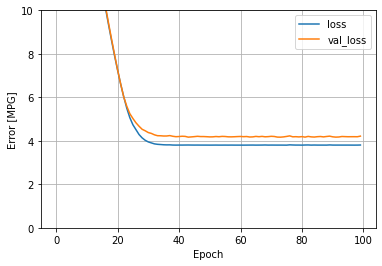

In [ ]:
plot_loss(history)

後で使用するために、テスト用セットの結果を収集します。

In [ ]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

これは単一変数の回帰であるため、入力の関数としてモデルの予測を簡単に確認できます。

In [ ]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

In [ ]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

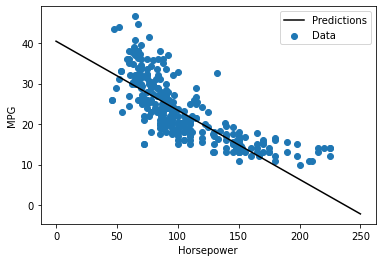

In [ ]:
plot_horsepower(x, y)

### 複数の入力

ほぼ同じ設定を使用して、複数の入力に基づく予測を実行することができます。このモデルでは、$m$ が行列で、$b$ がベクトルですが、同じ $y = mx+b$ を実行します。

ここでは、データセット全体に適合した `Normalization` レイヤーを使用します。

In [ ]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

入力のバッチでこのモデルを呼び出すと、各例に対して `units=1` 出力が生成されます。

In [ ]:
linear_model.predict(train_features[:10])

array([[ 0.519],
       [-0.202],
       [ 0.254],
       [-0.587],
       [-0.066],
       [ 0.25 ],
       [ 0.205],
       [-1.24 ],
       [ 0.805],
       [ 1.063]], dtype=float32)

モデルを呼び出すと、その重み行列が作成されます。これで、`kernel` ($y=mx+b$ の $m$) の形状が (9,1) であることがわかります。

In [ ]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[ 0.609],
       [-0.154],
       [ 0.205],
       [-0.666],
       [ 0.546],
       [-0.485],
       [-0.471],
       [-0.102],
       [ 0.073]], dtype=float32)>

Keras `Model.compile` でモデルを構成し、`Model.fit` で 100 エポックトレーニングします。

In [ ]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [ ]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 3.63 s, sys: 153 ms, total: 3.79 s
Wall time: 3.43 s


この回帰モデルですべての入力を使用すると、入力が 1 つだけの `horsepower_model` よりもトレーニングエラーや検証エラーが大幅に低くなります。

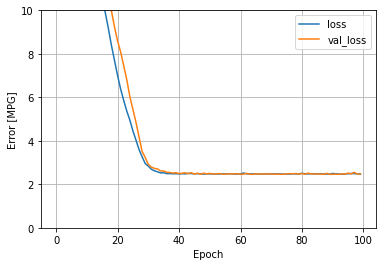

In [ ]:
plot_loss(history)

後で使用するために、テスト用セットの結果を収集します。

In [ ]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

## DNN 回帰

前のセクションでは、単一および複数の入力の線形モデルを実装しました。

このセクションでは、単一入力および複数入力の DNN モデルを実装します。コードは基本的に同じですが、モデルが拡張されていくつかの「非表示」の非線形レイヤーが含まれる点が異なります。「非表示」とは、入力または出力に直接接続されていないことを意味します。

コードは基本的に同じですが、モデルが拡張されていくつかの「非表示」の非線形レイヤーが含まれる点が異なります。「非表示」とは、入力または出力に直接接続されていないことを意味します。

これらのモデルには、線形モデルよりも多少多くのレイヤーが含まれます。

- 前と同じく正規化レイヤー。（単一入力モデルの場合は `horsepower_normalizer`、複数入力モデルの場合は `normalizer` を使用）。
- `relu` 非線形性を使用する 2 つの非表示の非線形`Dense` レイヤー。
- 線形単一出力レイヤー

どちらも同じトレーニング手順を使用するため、`compile` メソッドは以下の `build_and_compile_model` 関数に含まれています。

In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### DNN と単一入力を使用した回帰

入力 `'Horsepower'`、正規化レイヤー `horsepower_normalizer`（前に定義）のみを使用して DNN モデルを作成します。

In [ ]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

このモデルには、線形モデルよりも多少多くのトレーニング可能なレイヤーが含まれます。

In [ ]:
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


Keras `Model.fit` を使用してモデルをトレーニングします。

In [ ]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 4.02 s, sys: 178 ms, total: 4.2 s
Wall time: 5.54 s


このモデルは、単一入力の線形 `horsepower_model` よりもわずかに優れています。

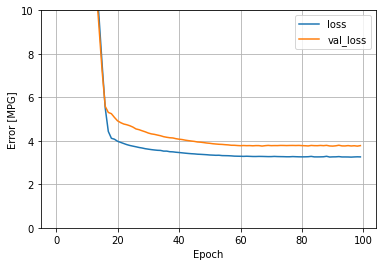

In [ ]:
plot_loss(history)

`Horsepower` の関数として予測をプロットすると、このモデルが非表示のレイヤーにより提供される非線形性をどのように利用するかがわかります。

In [ ]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

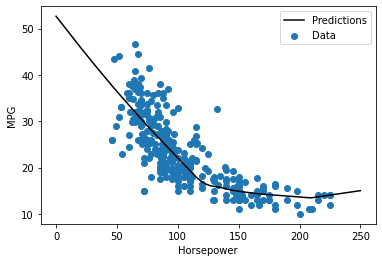

In [ ]:
plot_horsepower(x, y)

後で使用するために、テスト用セットの結果を収集します。

In [ ]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

### 完全モデル

すべての入力を使用してこのプロセスを繰り返すと、検証データセットの性能がわずかに向上します。

In [ ]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 9)                19        
 ion)                                                            
                                                                 
 dense_5 (Dense)             (None, 64)                640       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [ ]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 4.12 s, sys: 181 ms, total: 4.3 s
Wall time: 3.79 s


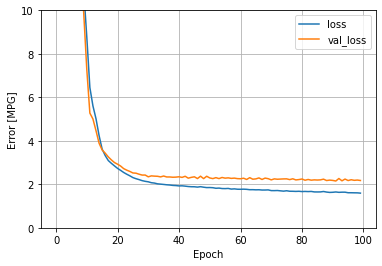

In [ ]:
plot_loss(history)

後で使用するために、テスト用セットの結果を収集します。

In [ ]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## 性能

すべてのモデルがトレーニングされたので、テスト用セットの性能を確認します。

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.642850
linear_model,2.509592
dnn_horsepower_model,2.906665
dnn_model,1.761291


これらの結果は、トレーニング中に見られる検証エラーと一致します。

### モデルを使った予測

Keras `Model.predict` を使用して、テストセットの `dnn_model` で予測を行い、損失を確認します。

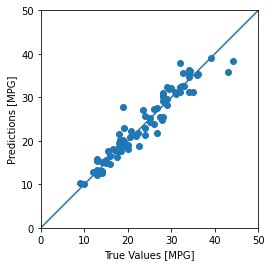

In [ ]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


モデルの予測精度は妥当です。

次に、エラー分布を見てみましょう。

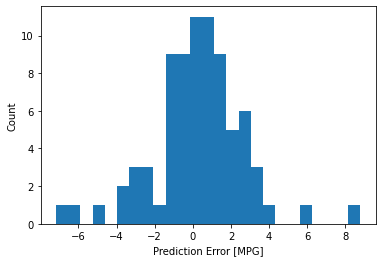

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

モデルに満足している場合は、後で使用できるように保存します。

In [ ]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


モデルを再度読み込むと、同じ出力が得られます。

In [ ]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.642850
linear_model,2.509592
dnn_horsepower_model,2.906665
dnn_model,1.761291
reloaded,1.761291


## まとめ

このノートブックでは、回帰問題を扱うためのテクニックをいくつか紹介しました。

- <a>平均二乗誤差 (MSE)</a> (`tf.keras.losses.MeanSquaredError`) および <a>平均絶対誤差 (MAE)</a> (`tf.keras.losses.MeanAbsoluteError`) は回帰問題に使われる一般的な損失関数です。MAE は外れ値の影響を受けにくくなっています。分類問題には異なる損失関数が使われます。
- 同様に、回帰問題に使われる評価指標も分類問題とは異なります。
- 入力数値特徴量の範囲が異なっている場合、特徴量ごとにおなじ範囲に正規化するべきです。
- 過適合は DNN モデルの一般的な問題ですが、このチュートリアルでは問題ではありませんでした。これに関する詳細については、オーバーフィットとアンダーフィットのチュートリアルを参照してください。